# Apply to financial applications

The present notebook will use the the library for a finance application. Specifically we want to solve a pricing problem. The reference for this notebook will be:

* NEASQC deliverable: *D5.1: Review of state-of-the-art for Pricing and Computation of VaR https://www.neasqc.eu/wp-content/uploads/2021/06/NEASQC_D5.1_Review-of-state-of-the-art-for-Pricing-and-Computation-of-VaR_R2.0_Final.pdf*

Given an input function $f(x)$ and a proability density $p(x)$ we want to compute the expected value of  $f(x)$ when x follows $p(x)$:

$$\mathbb{E}[f]=\int_a^bp(x)f(x)dx$$

This integral can be approximated by the Riemann sum:

$$\mathbb{E}[f] = \sum_{i=0}^{2^n-1} p(x_i)f(x_i)dx$$

The idea is to use **Amplitude Estimation** procedure in order to compute this value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
from copy import deepcopy

In [2]:
import sys
sys.path.append("../")

In [3]:
%matplotlib inline

In [4]:
#This cell loads the QLM solver.
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg (for using QPU as CESGA QLM one)
from libraries.utils.qlm_solver import get_qpu
QLMaaS = False
linalg_qpu = get_qpu(QLMaaS)

Using PyLinalg


In [5]:
#See 01_DataLoading_Module_Use for the use of this function
from libraries.utils.data_extracting import get_results

## 1. Discretizing data

Below cell defines the functions for $p(x)$ and $f(x)$

In [6]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

First thing to do is define a discrete version of these functions. We can use the *get_histogram* function from *utils/utils* module

In [7]:
from libraries.utils.utils import get_histogram

In [8]:
#number of Qbits for the circuit
n_qbits = 4

In [9]:
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

It is mandatory that $p(x)$ and $f(x)$ were properly normalized. Following conditions should be fullfilled:

* For $p(x)$ is mandatory that: $\sum_{i=0}^{2^{n}} p(x_i) = 1$
* For $f(x)$ is mandatory that: $f(x_i) \leq 1 \forall i$

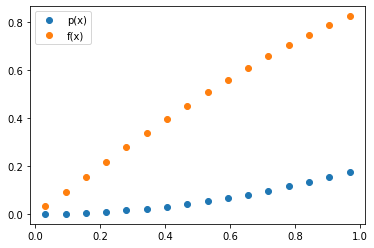

In [10]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['p(x)', 'f(x)'])

In [11]:
#Test condition in p(x)
print('p(x) condition: {}'.format(np.sum(p_X) == 1))
print('f(x) condition: {}'.format(np.max(f_X) <= 1))

p(x) condition: True
f(x) condition: True


## 2. Loading data

Second part is loading the data ($p(x)$ and $f(x)$) into the quantum state. For this we need to create following 2 loading operators:

1. $\mathcal{P}$. for loading $p(x)$
2. $\mathcal{F}$. for loading $f(x)$

So the main idea is begin with an initial $n+1$ qbits state:

$$|0\rangle \otimes|0\rangle_{n}$$

An apply the following loading operation:

$$|\Psi\rangle=\mathcal{F}\left(I\otimes\mathcal{P}\right)|0\rangle\otimes|0\rangle_{n}$$

The quantum state resulting from the loading proccess: $|\Psi\rangle$ can be expressed as a linear combination of two orthogonal states $|\Psi_{1}\rangle$ y $|\Psi_{0}\rangle$:

$$|\Psi\rangle=\sqrt{a}|\Psi_{0}\rangle+\sqrt{1-a}|\Psi_{1}\rangle$$

where:
$$
\begin{array}{l}
&\sqrt{a}|\Psi_{0}\rangle = |0\rangle \otimes\sum_{i=0}^{2^{n}-1}\sqrt{p(x_i)f(x_i)}|i\rangle_{n},\\\\
&\sqrt{1-a}|\Psi_{1}\rangle = |1\rangle\otimes\sum_{i=0}^{2^{n}-1}\sqrt{p(x_i)(1-f(x_i))}|i\rangle_{n}.
\end{array}
$$
The probability of measuring $|0\rangle$ is:

$$ \left|\sqrt{a}\right|^2 = \sum_{i=0}^{2^{n}-1}\left|\sqrt{p(x_i)f(x_i)}\right|^2,$$

so estimating $\sqrt{a}$ gives as an approximation of the value of the integral.

For doing this operations *load_probability* and *load_array* functions from **DL/data_loading** module will be used (see notebook **01_DataLoading_Module_Use.ipynb**)

In [12]:
from libraries.DL.data_loading import load_probability, load_array

In [13]:
p_gate = load_probability(p_X)
f_gate = load_array(np.sqrt(f_X))

In [14]:
%qatdisplay p_gate --depth 0
%qatdisplay f_gate --depth 0

Circuit printer failed on file /home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/qat2pdf_1zg8ftpd_circ
Traceback (most recent call last):
  File "printer.py", line 290, in qat.core.printer.toPdf
  File "/usr/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
FileNotFoundError: [Errno 2] No such file or directory: '/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/tmptjznx58f/qat2pdf_1zg8ftpd_circ.pdf'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/lib/python3.9/site-packages/qat/core/magic/magic.py", line 95, in plot
    toPdf(circuit, tmp_pdf_filename_radix, depth=depth)
  File "printer.py", line 295, in qat.core.printer.toPdf
RuntimeError: The command "pdflatex" did not generated a PDF file. Please ensure "standalone", "qc

RuntimeWarning('The PDF display is not working. Please use the "--pdf" option to display the error message or use the "--svg" option to remove this warning')

Circuit printer failed on file /home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/qat2pdf_a9d5183x_circ
Traceback (most recent call last):
  File "printer.py", line 290, in qat.core.printer.toPdf
  File "/usr/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
FileNotFoundError: [Errno 2] No such file or directory: '/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/tmppi8o697w/qat2pdf_a9d5183x_circ.pdf'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/lib/python3.9/site-packages/qat/core/magic/magic.py", line 95, in plot
    toPdf(circuit, tmp_pdf_filename_radix, depth=depth)
  File "printer.py", line 295, in qat.core.printer.toPdf
RuntimeError: The command "pdflatex" did not generated a PDF file. Please ensure "standalone", "qc

RuntimeWarning('The PDF display is not working. Please use the "--pdf" option to display the error message or use the "--svg" option to remove this warning')

Now we compound the two operators $\mathcal{P}$ aqnd $\mathcal{F}$ for creating the necesary loading circuit

In [15]:
routine = qlm.QRoutine()
register = routine.new_wires(f_gate.arity)
routine.apply(p_gate, register[:p_gate.arity])
routine.apply(f_gate, register)

In [16]:
%qatdisplay routine --depth 0

Circuit printer failed on file /home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/qat2pdf_4nom5a0i_circ
Traceback (most recent call last):
  File "printer.py", line 290, in qat.core.printer.toPdf
  File "/usr/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
FileNotFoundError: [Errno 2] No such file or directory: '/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/tmp7r9sn3vh/qat2pdf_4nom5a0i_circ.pdf'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/lib/python3.9/site-packages/qat/core/magic/magic.py", line 95, in plot
    toPdf(circuit, tmp_pdf_filename_radix, depth=depth)
  File "printer.py", line 295, in qat.core.printer.toPdf
RuntimeError: The command "pdflatex" did not generated a PDF file. Please ensure "standalone", "qc

RuntimeWarning('The PDF display is not working. Please use the "--pdf" option to display the error message or use the "--svg" option to remove this warning')

We can test if the loading was properly implemented. For doing this we are going to use **get_results** from *data_extracting* module

In [17]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

In [18]:
np.isclose(quantum_probabilities[0:2**p_gate.arity], p_X*f_X).all()

True

We are going to measure the complete state (**phi_state**) and the last qbit state (**InitialState**)

In [19]:
phi_state,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)#, qubits=[f_gate.arity-1])
InitialState,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu, qubits=[f_gate.arity-1])

In [20]:
np.isclose(InitialState['Probability'].iloc[0], sum(p_X*f_X))

True

## 3. Maximum Likelihood Amplitude Estimation

Quantum circuit implementation of $\mathcal{QFT}$ are very complex and very long and deep so its use in actual quantum computers is noisy and not very useful.

The **Maximum Likelihood Amplitude Estimation** algorithm (**MLAE**) allows to take advantage of **amplitude amplification** without the use of the  $\mathcal{QFT}$.

For doing this  we are going to use the  **maximum_likelihood_ae** module 

In [21]:
from  libraries.AE.maximum_likelihood_ae  import MLAE

The notebook **04_MaximumLikelihood_Class** explains how this class works. In our case we need to provide:

1. Oracle
2. Target: the binnary representation of the marked state. 
3. index: the registers where the Target is.

In our case is the same that we use for generating Grover-like operator

In [22]:
oracle = deepcopy(routine)
target = [0]
index = [routine.arity-1]

In [23]:
%qatdisplay oracle

Circuit printer failed on file /home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/qat2pdf_6oc38p1m_circ
Traceback (most recent call last):
  File "printer.py", line 290, in qat.core.printer.toPdf
  File "/usr/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
FileNotFoundError: [Errno 2] No such file or directory: '/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/tmpz4o_lebb/qat2pdf_6oc38p1m_circ.pdf'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/lib/python3.9/site-packages/qat/core/magic/magic.py", line 95, in plot
    toPdf(circuit, tmp_pdf_filename_radix, depth=depth)
  File "printer.py", line 295, in qat.core.printer.toPdf
RuntimeError: The command "pdflatex" did not generated a PDF file. Please ensure "standalone", "qc

RuntimeWarning('The PDF display is not working. Please use the "--pdf" option to display the error message or use the "--svg" option to remove this warning')

Additionally a schedule where the list of applications of Grover-like operator should be provided

In [24]:
m_k = list(range(5))
n_k = [100]*len(m_k)
schedule = [m_k,n_k]

In [25]:
mlae = MLAE(
    oracle,target = target,
    index = index,
    schedule = schedule)

In [26]:
mlae.schedule

array([[  0,   1,   2,   3,   4],
       [100, 100, 100, 100, 100]])

In [27]:
angle = mlae.optimize()

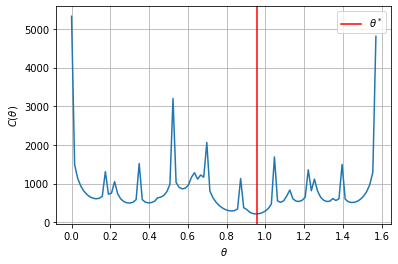

In [28]:
#ploting the Cost function
angles = np.linspace(0+mlae.delta,np.pi/2-mlae.delta,100)
cost = np.zeros(len(angles))
for i in range(len(angles)):
    cost[i] = mlae.cost_function(angles[i])

plt.plot(angles, cost)
plt.axvline(np.arcsin(sum(p_X*f_X)**0.5), color = 'r',label = r"$\theta^*$")

#plt.axvline(theta,color = 'r')
plt.grid()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$C(\theta)$")

plt.legend()

In this case the aproximation of the integral $\mathbb{E}[f]\approx \sum_{i=0}^{2^{n}-1}\left|\sqrt{p(x_i)f(x_i)}\right|^2 $ aproximated as:

$$\sin^2(\theta),$$ 

where $\theta$ is the angle calculated with the **MLAE** algortihm. See notebook **03_MaximumLikelihood_Class** for more information. 

In [29]:
print("Quantum result: ",np.sin(angle)[0]**2)
print('Integral Result: ', sum(p_X*f_X))
print('Difference: ', abs(np.sin(angle)[0]**2-sum(p_X*f_X)))

Quantum result:  0.6642398020727426
Integral Result:  0.6693004071633366
Difference:  0.005060605090594028


## 4. Kitaev's Iterative Quantum Amplitude Estimation

Another alternative to estimate the amplitude is using  *Iterative Quantum Phase Estimation* to do *Quantum Amplitude Estimation*.
For using **IterativeQuantumPE** we need to provide:

* initial_state : in this case will be the oracle
* unitary_operator:  in this case will be the Grover-like operator build using *oracle* 
* cbits_number: number of classical bits used for phase estimation

For creating the grover operator we are going to use the *grover* function from *amplitude_amplification* module and the same *target* and *index*  then in the *maximum likelihood* class will be used:

In [30]:
from libraries.AA.amplitude_amplification import grover

In [31]:
target = [0]
index = [oracle.arity-1]
q_gate = grover(oracle, target, index)

In [32]:
%qatdisplay q_gate --depth 1

Circuit printer failed on file /home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/qat2pdf_xnl8yjdt_circ
Traceback (most recent call last):
  File "printer.py", line 290, in qat.core.printer.toPdf
  File "/usr/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
FileNotFoundError: [Errno 2] No such file or directory: '/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/QuantumComputing/notebooks/tmp1rprlmdq/qat2pdf_xnl8yjdt_circ.pdf'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/albertomanzano/Documents/Thesis/Quantum/QuantumComputing/lib/python3.9/site-packages/qat/core/magic/magic.py", line 95, in plot
    toPdf(circuit, tmp_pdf_filename_radix, depth=depth)
  File "printer.py", line 295, in qat.core.printer.toPdf
RuntimeError: The command "pdflatex" did not generated a PDF file. Please ensure "standalone", "qc

RuntimeWarning('The PDF display is not working. Please use the "--pdf" option to display the error message or use the "--svg" option to remove this warning')

In [33]:
#Load Class
from libraries.PE.iterative_quantum_pe import IterativeQuantumPE

In [34]:
n_cbits = 7
#We create a python dictionary for configuration of class
iqpe_dict = {
    'initial_state': oracle,
    'unitary_operator': q_gate,
    'qpu' : linalg_qpu,
    'cbits_number' : n_cbits,
    'shots': 100
    #'easy': True,
    #'easy': False    
}
IQPE = IterativeQuantumPE(**iqpe_dict)

In [35]:
IQPE.iqpe()

In [36]:
IQPE.final_results

,BitString,BitInt,Phi,2*theta,theta,theta_90
0,1100111,103,0.804688,5.056001,2.528000,0.613592
1,0011001,25,0.195312,1.227185,0.613592,0.613592
2,1100111,103,0.804688,5.056001,2.528000,0.613592
3,1100111,103,0.804688,5.056001,2.528000,0.613592
4,0011001,25,0.195312,1.227185,0.613592,0.613592
...,...,...,...,...,...,...
95,1100111,103,0.804688,5.056001,2.528000,0.613592
96,0011001,25,0.195312,1.227185,0.613592,0.613592
97,0011001,25,0.195312,1.227185,0.613592,0.613592
98,0011001,25,0.195312,1.227185,0.613592,0.613592


In this case the aproximation of the integral $\mathbb{E}[f]\approx \sum_{i=0}^{2^{n}-1}\left|\sqrt{p(x_i)f(x_i)}\right|^2 $ aproximated as:

$$\cos^2(\theta),$$ 

where $\theta$ is the angle calculated with the **IQPE** algortihm. See notebook **04_Iterative_QPE_Class** for more information. 

In [37]:
pdf = IQPE.sumary
pdf['P']=np.cos(pdf['theta_90'])**2

In [38]:
pdf

,theta_90,Freqcueny,P
0,0.613592,58,0.668445
1,0.613592,42,0.668445


In [39]:
print("Classical result: ", np.sum(p_X*f_X))
print("Quantum result: ",pdf.iloc[0]['P'])

Classical result:  0.6693004071633366
Quantum result:  0.66844492669611
